Import all dependencies

In [16]:
from typing import Dict, Tuple
from matplotlib import pyplot as plt
from numba import cuda
import numpy as np
import cv2
import math

Helper functions for displaying images

In [17]:
def show_image(img: np.ndarray, window_name: str) -> None:
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(window_name)
    plt.show()

def show_subplot(named_imgs: Dict[str, np.ndarray], img_shape: np.ndarray.shape) -> None:
    f, axarr = plt.subplots(1, len(named_imgs))
    f.set_figheight(len(named_imgs)*4)
    f.set_figwidth(len(named_imgs)*4)

    for idx, (name, img) in enumerate(named_imgs.items()):
        out_img = None
        
        # Copy the image from device or host memory
        if (cuda.is_cuda_array(img)):
            out_img = img.copy_to_host()
            out_img = out_img.reshape(img_shape)
        else:
            out_img = img.copy()

        # Ensure image is within bounds
        if (out_img.min() < 0 or out_img.max() > 1):
            out_img = np.clip(out_img, 0, 1)

        # BW to color
        if (out_img.ndim == 2):
            out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2RGB)

        axarr[idx].set_title(name)
        axarr[idx].imshow(out_img)

Default kernels

In [18]:
kernel_sobel_left = cuda.to_device(np.array([[ 1,  0, -1], 
                                             [ 2,  0, -2], 
                                             [ 1,  0, -1]], np.float32))

kernel_sobel_top  = cuda.to_device(np.array([[ 1,  2,  1], 
                                             [ 0,  0,  0], 
                                             [-1, -2,  -1]], np.float32))

kernel_sharpen    = cuda.to_device(np.array([[ 0, -1,  0], 
                                             [-1,  5, -1], 
                                             [ 0, -1,  0]], np.float32))

kernel_blur_3     = cuda.to_device(np.array([[ 1,  2,  1], 
                                             [ 2,  4,  2], 
                                             [ 1,  2,  1]], np.float32) / 16)

kernel_blur_5     = cuda.to_device(np.array([[1,  4,  6,  4,  1], 
                                             [4, 16, 24, 16,  4], 
                                             [6, 24, 36, 24,  6],
                                             [4, 16, 24, 16,  4],
                                             [1,  4,  6,  4,  1]], np.float32) / 256)

Load the base image

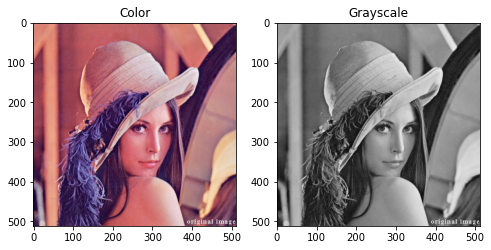

In [19]:
raw_img = cv2.imread('imgs/lena_color.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
raw_bw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2GRAY)

# Normalize to 0..1
col_img = raw_img.astype(np.float32)
col_img /= 255.
bw_img = raw_bw_img.astype(np.float32)
bw_img /= 255.

# Create cuda image to work with
cuda_img_input = cuda.to_device(bw_img.ravel())

show_subplot({"Color": col_img, "Grayscale": bw_img}, bw_img.shape)

Generate cuda kernel dimensions

In [20]:
imgH = bw_img.shape[0]
imgW = bw_img.shape[1]
cuda_img_shape = cuda.to_device(bw_img.shape)

blockSize = imgW
blockPerLine = 1

if (imgW > 1024):
    blockSize = 256
    blockPerLine = math.ceil(imgW / blockSize)

# Each px will have its own cuda thread
gridDim = (blockPerLine, imgH)
blockDim = (blockSize, 1)

Init all the images buffers we will need

In [21]:
cuda_img_sharpen      = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_blur3        = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_blur5        = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_sobel_top    = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_sobel_left   = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_sobel        = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_thinned      = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_thresh_upper = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_thresh_lower = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_hysteresis   = cuda.device_array(cuda_img_input.shape, np.float32)

Create function for generating convolutions

In [22]:
# Func returns the x/y index relative to the kernel center being location (0,0)
@cuda.jit(device=True)
def get_kernel_center_offset(k_size: int, x: int, y: int) -> Tuple[int, int]:
    target = int(k_size/2) + 1
    out_x = (x-target) +1
    out_y = (y-target) +1

    return out_x, out_y

# We launch one cuda thread per px. Each launch will represent a px output location
@cuda.jit
def convolve(cuda_img_in: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_img_kernel: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray, normalize: bool) -> None:
    imgH = cuda_img_shape[0]
    imgW = cuda_img_shape[1]
    
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_out_idx = img_row * imgW + img_col

    px_out = 0

    kern_pos = 0
    kern_neg = 0

    # We could use len(kernel.ravel) as the grid.z rather than looping, but writing px will have to become an atomic add...
    for ker_y in range(cuda_img_kernel.shape[0]):
        for ker_x in range(cuda_img_kernel.shape[1]):
            if cuda_img_kernel[ker_y, ker_x] > 0:
                kern_pos += cuda_img_kernel[ker_y, ker_x]
            if cuda_img_kernel[ker_y, ker_x] < 0:
                kern_neg += cuda_img_kernel[ker_y, ker_x]

            ker_offset_x, ker_offset_y = get_kernel_center_offset(cuda_img_kernel.shape[0], ker_x, ker_y)

            # If out-of-bounds, use a valid neighbor px
            if (img_col+ker_offset_x < 0) or (img_col+ker_offset_x > imgW):
                ker_offset_x = 0
            if (img_row+ker_offset_y < 0) or (img_row+ker_offset_y > imgH):
                ker_offset_y = 0

            img_in_idx = ((img_row + ker_offset_y) * imgW) + (img_col + ker_offset_x)
            px_out += (cuda_img_in[img_in_idx] * cuda_img_kernel[ker_y, ker_x])
    
    if (normalize):
        px_out = (px_out - kern_neg) / (kern_pos - kern_neg)

    cuda_img_out[img_out_idx] = px_out

Generate and display various convolutions 

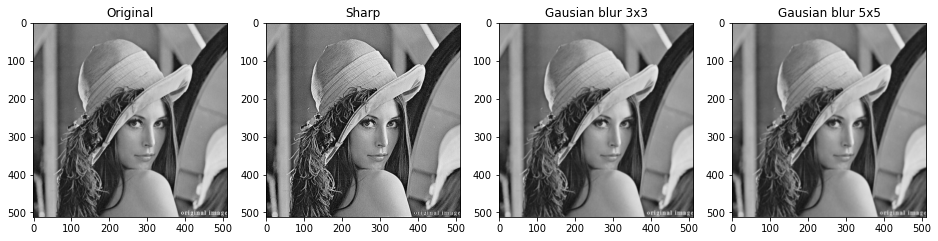

In [23]:
convolve[gridDim, blockDim](cuda_img_input, cuda_img_shape, kernel_sharpen, cuda_img_sharpen, False)
convolve[gridDim, blockDim](cuda_img_input, cuda_img_shape, kernel_blur_3, cuda_img_blur3, True)
convolve[gridDim, blockDim](cuda_img_input, cuda_img_shape, kernel_blur_5, cuda_img_blur5, True)

show_subplot({'Original': bw_img,
              'Sharp': cuda_img_sharpen,
              'Gausian blur 3x3': cuda_img_blur3,
              'Gausian blur 5x5': cuda_img_blur5}, bw_img.shape)

Cuda kernels for hypot and arctan

In [24]:
@cuda.jit
def hypot_img(cuda_img_a: cuda.np.ndarray, cuda_img_b: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * cuda_img_shape[1] + img_col

    cuda_img_out[img_idx] = math.sqrt((cuda_img_a[img_idx]**2) + (cuda_img_b[img_idx]**2))

# TODO
#@cuda.jit
#def arctan2_img(cuda_img_a: cuda.np.ndarray, cuda_img_b: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:

Generate the sobel from top and left filters

In [25]:
# Detect edges
convolve[gridDim, blockDim](cuda_img_blur5, cuda_img_shape, kernel_sobel_top, cuda_img_sobel_top, False)
convolve[gridDim, blockDim](cuda_img_blur5, cuda_img_shape, kernel_sobel_left, cuda_img_sobel_left, False)
hypot_img[gridDim, blockDim](cuda_img_sobel_top, cuda_img_sobel_left, cuda_img_shape, cuda_img_sobel)

theta = np.arctan2(cuda_img_sobel_top.copy_to_host(), cuda_img_sobel_left.copy_to_host())

Use non-max suppression as the thinning algorithm

In [26]:
# TODO
#@cuda.jit
#def non_max_suppression(cuda_img_in: cuda.np.ndarray, cuda_img_theta: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:

# Thins lines based on the intensity of the prev/next px
def non_max_suppression(img: np.ndarray, theta: np.ndarray) -> np.ndarray:
    out_img = np.zeros(img.shape, np.float32)
    imgH = img.shape[0]
    imgW = img.shape[1]
    angle = theta * 180. / np.pi # Convert radians to degrees
    angle[angle < 0] += 180 # Make range 0 to 180 instead of -180 to 180


    for img_y in range(1, imgH-1):
        for img_x in range(1, imgW-1):
            px_before = 0.
            px_after = 0.
            px_curr = img[img_y, img_x]
            curr_angle = angle[img_y, img_x]

            if (0 <= curr_angle < 22.5) or (157.5 <= curr_angle <= 180): # Angle 0
                px_before = img[img_y, img_x-1]
                px_after = img[img_y, img_x+1]
            elif (22.5 <= curr_angle < 67.5): # Angle 45
                px_before = img[img_y-1, img_x+1]
                px_after = img[img_y+1, img_x-1]
            elif (67.5 <= curr_angle < 112.5): # Angle 90
                px_before = img[img_y-1, img_x]
                px_after = img[img_y+1, img_x]
            elif (112.5 <= curr_angle < 157.5): # Angle 135
                px_before = img[img_y-1, img_x-1]
                px_after = img[img_y+1, img_x+1]

            if (px_before <= px_curr >= px_after):
                out_img[img_y, img_x] = px_curr
            else:
                out_img[img_y, img_x] = 0

    return out_img

Thin the image and show the image steps 

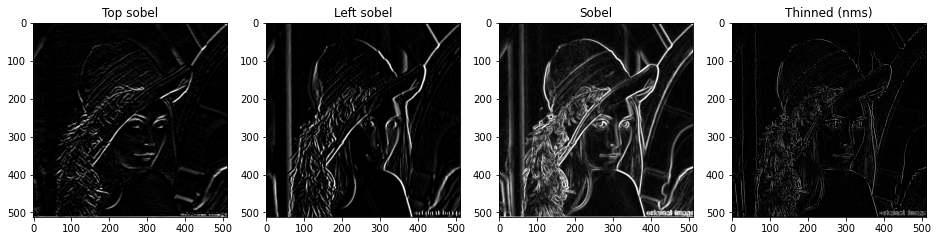

In [27]:
img_nms = non_max_suppression(cuda_img_sobel.copy_to_host().reshape(bw_img.shape), theta.reshape(bw_img.shape))

show_subplot({'Top sobel': cuda_img_sobel_top,
              'Left sobel': cuda_img_sobel_left,
              'Sobel': cuda_img_sobel,
              'Thinned (nms)': img_nms}, bw_img.shape)

Function for generating connected component labels

In [28]:
# TODO
#@cuda.jit
#def ccl(cuda_img_in: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:

Function for hysteresis to combine various thresholds

In [29]:
# TODO
#@cuda.jit
#def hysteresis(cuda_img_upper: cuda.np.ndarray, cuda_img_lower: cuda.np.ndarray, cuda_ccl: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:

Generate canny edges using hysteresis

In [30]:
# TODO
# 1. Get upper and lower thresholds
# 2. Get CCL of lower image for expansion in hysteresis
# 3. Get the union mask of both threholds

# TODO: For display
# Make hysteresis image 3 channel to show what was added from the lower thresh image
# Overlay the result on the original image

# Use cv2.canny as a comparison
#img_cv2_canny = cv2.Canny(raw_bw_img, 100, 240, apertureSize=3)
#img_overlay2 = np.dstack((raw_bw_img, raw_bw_img, raw_bw_img))
#img_overlay2[img_cv2_canny == img_cv2_canny.max()] = (255,0,0)

#show_subplot({f'Threshold {upper_thresh}': img_upper_thresh, f'Threshold {lower_thresh}': img_lower_thresh, 'Hysteresis': img_thresh_color})
#show_subplot({'Our canny': img_overlay1, 'OpenCV canny': img_overlay2})